### orbit of a planet in the potential of a star

In [105]:
import sys
import os
sys.path.append(os.path.relpath('/Users/edoardo/AstroCosmoComputational/Students/MaraglianoEdo/'))

In [106]:
import numpy as np
from pyACC import calculus
from pyACC import cosmology

In [107]:
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [108]:
from scipy.interpolate import RegularGridInterpolator, interp1d, interp2d
from astropy.constants import G

### define the potential of a set of masses

In [109]:
def gravitational_potential_function(masses, positions):
    G = 1
    n = len(masses)

    if(len(masses)!=len(positions)):
       raise RuntimeError('len masses != len positions')

    def potential_function(coordinates):
        potential = np.zeros_like(coordinates[..., 0])  # Initialize potential array

        for i in range(n):
    
            # Calculate distance between mass i and mass j
            r = np.sqrt(np.sum((coordinates - positions[i])**2, axis=-1))

            ## coordinates is a grid, of shape (len(x),len(y),len(z))
            ## positions[i] is a 3d array
            ## positions[i] is subtracted to all the elements of coordinates

            # Calculate gravitational potential energy between mass i and mass j
            potential += - G * masses[i] / r

        return potential

    return potential_function


In [110]:

masses = np.array([10])  # Masses of the objects
positions = np.array([[0.0, 0.0, 0.0]])  # Positions of the objects (3D)

potential_function = gravitational_potential_function(masses, positions)

# Generate coordinates grid
x = np.arange(-100, 100, 0.5)
y = np.arange(-100, 100, 0.5)
z = np.arange(-30, 30, 0.5)                                 ### everything happens on the orbital plane z=0
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
coordinates = np.stack((X, Y, Z), axis=-1)
print(coordinates.shape)
# Calculate potential at all points
potential_at_points = potential_function(coordinates)
#print("Gravitational Potential Energy at all points:")
#print(potential_at_points[:,:,0])

(400, 400, 120, 3)


/var/folders/lt/rxl5tbq10jx7cr45nr6962zm0000gq/T/ipykernel_7758/140571435.py:21: RuntimeWarning: divide by zero encountered in divide
  potential += - G * masses[i] / r


60


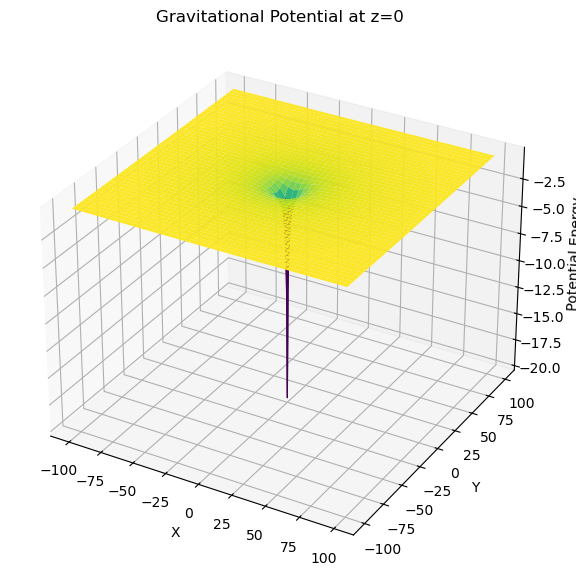

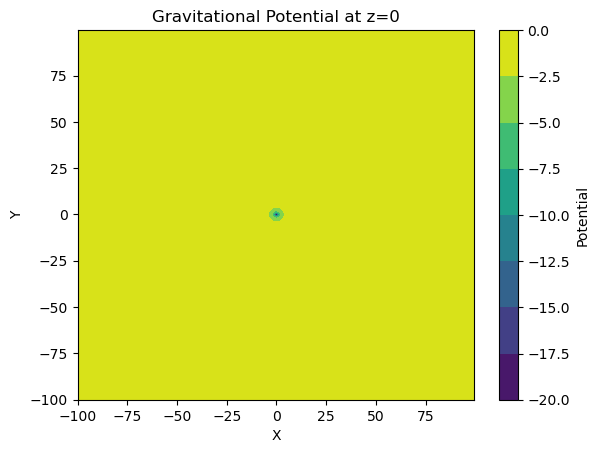

In [111]:
# Plot 3D
mid = int(len(z)/2)
print(mid)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X[:,:,mid], Y[:,:,mid], potential_at_points[:,:,mid], cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Potential Energy')
ax.set_title('Gravitational Potential at z=0')
plt.show()

# Plot contour
plt.contourf(X[:,:,mid], Y[:,:,mid], potential_at_points[:,:,mid], cmap='viridis')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Gravitational Potential at z=0')
plt.colorbar(label='Potential')
plt.show()

### compute the gradient of the potential

In [112]:
gx,gy,gz =  np.gradient(-potential_at_points, x,y,z)

In [113]:
field_x = RegularGridInterpolator((x,y,z), gx)
field_y = RegularGridInterpolator((x,y,z), gy)
field_z = RegularGridInterpolator((x,y,z), gz)

In [114]:
m_test = 0.001

def g(pos, field):
    f_x = field[0](pos)[0]
    f_y = field[1](pos)[0]
    f_z = field[2](pos)[0]
    return np.array([f_x,f_y,f_z])

In [115]:
r_0 = [0,0,0]

In [116]:
g([0,0,0], [field_x, field_y, field_z])

/Users/edoardo/miniconda3/envs/acc-env/lib/python3.9/site-packages/scipy/interpolate/_rgi.py:418: RuntimeWarning: invalid value encountered in multiply
  term = np.asarray(self.values[edge_indices]) * weight[vslice]


array([nan, nan, nan])

In [117]:
def equation_of_motion(R,V):
    return g(R, [field_x, field_y, field_z] )

In [118]:
def rk4_step(R, V, dt, equation_of_motion):
    """
    Perform one step of the fourth-order Runge-Kutta method for a single body.

    Parameters:
        R: numpy array, position of the body. Shape: (3,).
        V: numpy array, velocity of the body. Shape: (3,).
        dt: float, time step size.
        equation_of_motion: function, computes the acceleration of the body.

    Returns:
        Tuple of numpy arrays, updated position and velocity.
    """
    # Compute the acceleration at the initial position and velocity
    k1v = equation_of_motion(R, V)
    k1r = V

    # Compute the acceleration at the midpoint using the initial values
    k2v = equation_of_motion(R + 0.5 * dt * k1r, V + 0.5 * dt * k1v)
    k2r = V + 0.5 * dt * k1v

    # Compute the acceleration at the midpoint using the midpoint values
    k3v = equation_of_motion(R + 0.5 * dt * k2r, V + 0.5 * dt * k2v)
    k3r = V + 0.5 * dt * k2v

    # Compute the acceleration at the end using the midpoint values
    k4v = equation_of_motion(R + dt * k3r, V + dt * k3v)
    k4r = V + dt * k3v

    # Compute the weighted sum of the four increments to obtain the final position and velocity
    R_new = R + (dt / 6.0) * (k1r + 2 * k2r + 2 * k3r + k4r)
    V_new = V + (dt / 6.0) * (k1v + 2 * k2v + 2 * k3v + k4v)

    return R_new, V_new

In [129]:
n_steps = [2000, 8000,9000]
dt = 0.01
r0 = [-10,10,0]
velocities = [ [0,-2,0], [0,-1.2,0], [0,-0.8,0]]

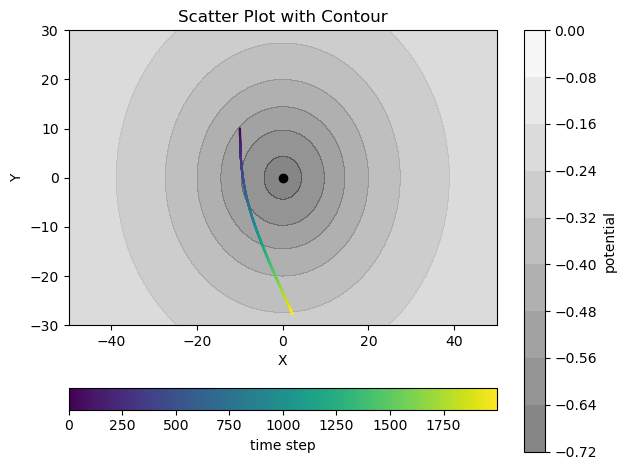

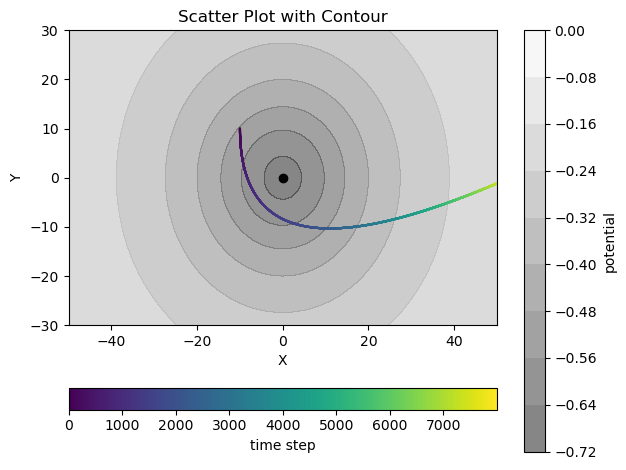

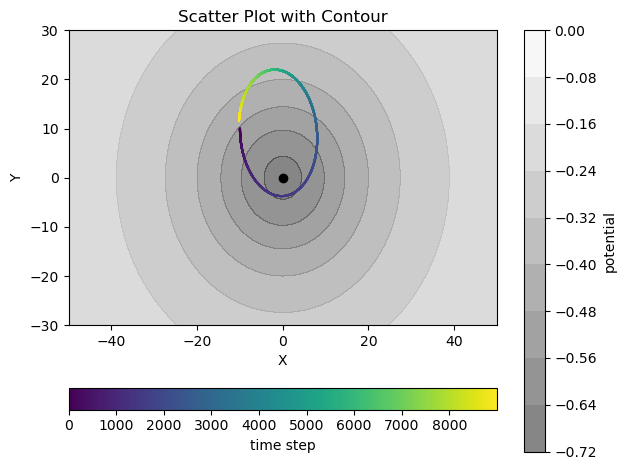

In [130]:
for v0, n_step in zip(velocities, n_steps):
    r_of_t = np.zeros((n_step, 3))
    v_of_t = np.zeros((n_step, 3))
    r_of_t[0]=r0
    v_of_t[0]=v0

    time_index = np.arange(n_step)

### INSERT A CHECK THAT THE POSITION IS IN THE GRID

    for i in range(1,n_step):
        r_of_t[i], v_of_t[i] = rk4_step(r_of_t[i-1], v_of_t[i-1], dt, equation_of_motion)

    # Plot trajectory over contour
    
    contour = plt.contourf(X[:,:,30], Y[:,:,30], potential_at_points[:,:,30], cmap='gist_gray', alpha=0.5)
    scatter = plt.scatter(r_of_t[:,0], r_of_t[:,1], marker='.', s=1, c=time_index, cmap='viridis')
    plt.scatter(positions[:,0], positions[:,0], marker='o', color='k')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(-50,50)
    plt.ylim(-30,30)
    plt.title('Scatter Plot with Contour')

    # Top right: Vertical color bar for contour

    cbar_contour = fig.colorbar(contour, orientation='vertical')
    cbar_contour.set_label('potential')

    # Bottom left: Horizontal color bar for scatter plot
    
    cbar_scatter = fig.colorbar(scatter, orientation='horizontal')
    cbar_scatter.set_label('time step')

    plt.tight_layout()
    plt.show()
